In [12]:
import warnings
warnings.filterwarnings('ignore')

The warning filter has been added to the beginning of the notebook. Now, let's re-run the import cell.

In [13]:
from mlxtend.frequent_patterns import fpgrowth, association_rules, apriori
import pandas as pd
import numpy as np

In [14]:
merged_df = pd.read_csv('/content/engineered_retail_dataset__for_ml.csv')
merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Weekly_Sales_Lag2,Weekly_Sales_Lag3,Weekly_Sales_MA4,Weekly_Sales_STD4,Weekly_Sales_MA12,Weekly_Sales_STD12,IsHoliday_Lag1,IsHoliday_Lead1,Rolling_4,Rolling_12
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,...,0.00,0.00,0.00,0.000000,0.0,0.0,False,True,0.00,0.0
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.0,0.0,0.0,...,0.00,0.00,0.00,0.000000,0.0,0.0,False,False,0.00,0.0
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.0,0.0,0.0,...,24924.50,0.00,0.00,0.000000,0.0,0.0,True,False,0.00,0.0
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.0,0.0,0.0,...,46039.49,24924.50,0.00,0.000000,0.0,0.0,False,False,0.00,0.0
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.0,0.0,0.0,...,41595.55,46039.49,32990.77,12832.106391,0.0,0.0,False,False,32990.77,0.0


In [8]:
import warnings
warnings.catch_warnings(record=True)

catch_warnings(record=True)

In [16]:
# Step 1: Pick Top 10 Departments by Total Sales
top_depts = merged_df.groupby("Dept")["Weekly_Sales"].sum().nlargest(10).index

# Step 2: Filter dataset to only those top departments
filtered_df = merged_df[merged_df["Dept"].isin(top_depts)]

# Step 3: Create a basket-like structure (per Store-Date, which acts like a transaction)
basket = (filtered_df
          .groupby(['Store', 'Date', 'Dept'])['Weekly_Sales']
          .sum()
          .unstack(fill_value=0))

# Step 4: Convert to binary (1 if sales > 0, else 0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)


In [17]:
# Step 5: Run FP-Growth
frequent_itemsets = fpgrowth(basket, min_support=0.05, use_colnames=True)

In [18]:
frequent_itemsets_apriori = apriori(basket, min_support=0.05, use_colnames=True)

In [19]:
# Step 6: Generate Association Rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

In [20]:
# Display top rules
print("Frequent Itemsets:")
print(frequent_itemsets.sort_values(by="support", ascending=False).head(10))

Frequent Itemsets:
      support                            itemsets
1012      1.0  (2, 38, 8, 40, 13, 90, 91, 92, 95)
0         1.0                                (95)
1         1.0                                (92)
2         1.0                                (91)
3         1.0                                (90)
995       1.0      (2, 38, 8, 40, 13, 90, 91, 95)
988       1.0      (2, 38, 8, 40, 13, 90, 92, 95)
982       1.0      (2, 38, 8, 40, 13, 91, 92, 95)
36        1.0                             (8, 90)
35        1.0                            (90, 38)


In [21]:
print("\nAssociation Rules:")
print(rules.sort_values(by="lift", ascending=False).head(10))


Association Rules:
      antecedents                         consequents  antecedent support  \
57001        (95)  (2, 38, 8, 40, 72, 13, 90, 91, 92)                 1.0   
0            (92)                                (95)                 1.0   
1            (95)                                (92)                 1.0   
2            (91)                                (95)                 1.0   
3            (95)                                (91)                 1.0   
4            (90)                                (95)                 1.0   
5            (95)                                (90)                 1.0   
6            (40)                                (95)                 1.0   
7            (95)                                (40)                 1.0   
8            (38)                                (95)                 1.0   

       consequent support   support  confidence  lift  representativity  \
57001            0.934266  0.934266    0.934266   1.0    

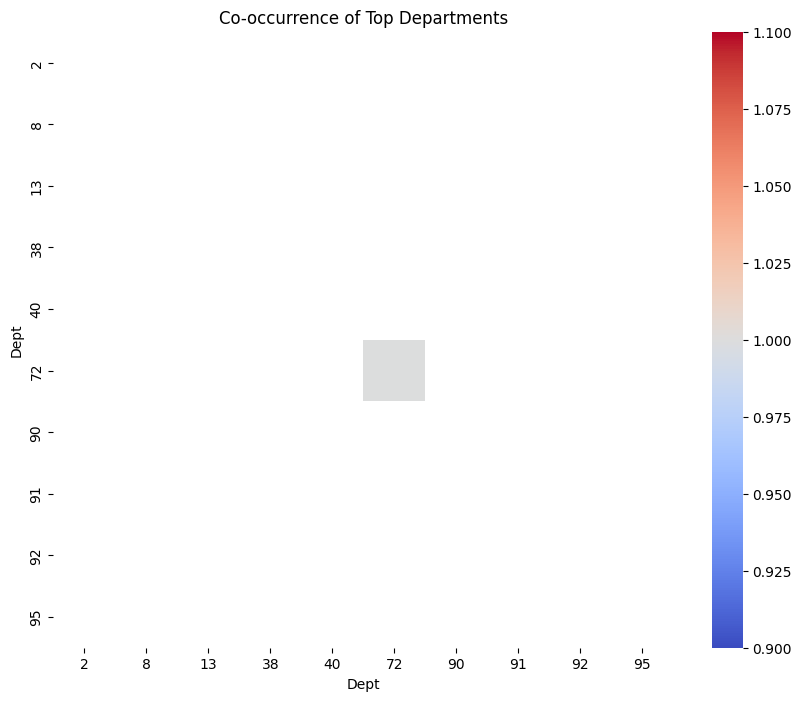

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = basket.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Co-occurrence of Top Departments")
plt.show()

In [23]:
import itertools
from collections import Counter

co_occurrence = Counter()
for _, row in basket.iterrows():
    items = row[row==1].index.tolist()
    for pair in itertools.combinations(items, 2):
        co_occurrence[pair] += 1

# Convert to dataframe
co_df = pd.DataFrame(co_occurrence.items(), columns=["Pair", "Count"])
co_df = co_df.sort_values("Count", ascending=False)
print(co_df.head(10))


       Pair  Count
0    (2, 8)   6435
1   (2, 13)   6435
2   (2, 38)   6435
3   (2, 40)   6435
5   (2, 90)   6435
9   (8, 13)   6435
6   (2, 91)   6435
7   (2, 92)   6435
8   (2, 95)   6435
11  (8, 40)   6435


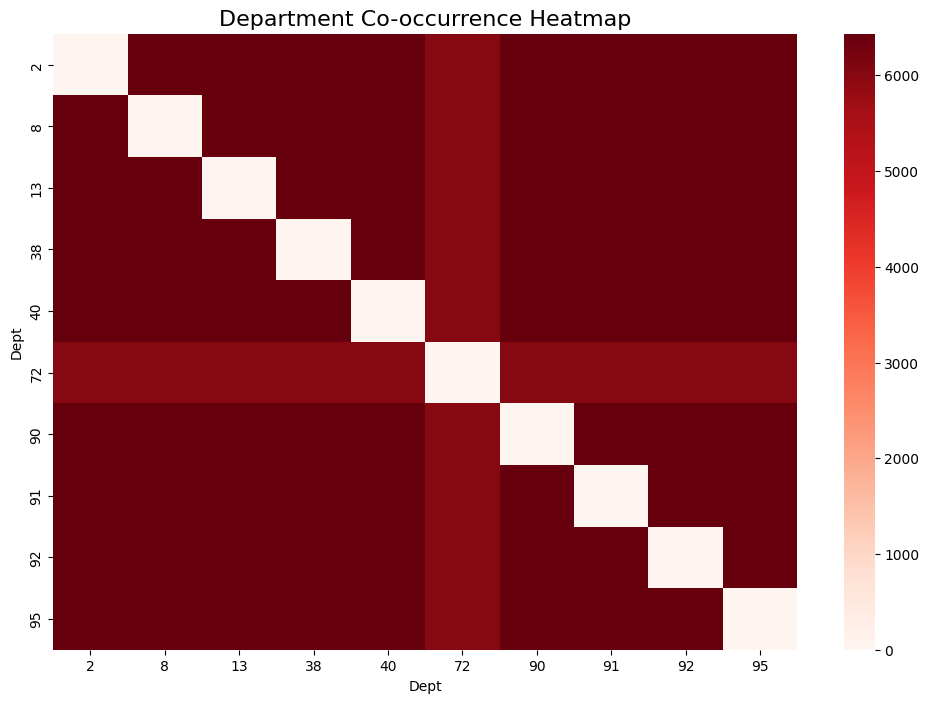

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert to matrix
co_matrix = pd.DataFrame(0, index=basket.columns, columns=basket.columns)
for (i, j), val in co_occurrence.items():
    co_matrix.loc[i, j] = val
    co_matrix.loc[j, i] = val

plt.figure(figsize=(12,8))
sns.heatmap(co_matrix, cmap="Reds")
plt.title("Department Co-occurrence Heatmap", fontsize=16)
plt.show()


Top Co-occurring Department Pairs:


,Pair,Count
0,"(1, 2)",6435
2615,"(92, 95)",6435
2610,"(91, 95)",6435
1,"(1, 3)",6435
18,"(1, 21)",6435
2607,"(91, 92)",6435
2604,"(90, 95)",6435
422,"(7, 13)",6435
423,"(7, 14)",6435
424,"(7, 16)",6435


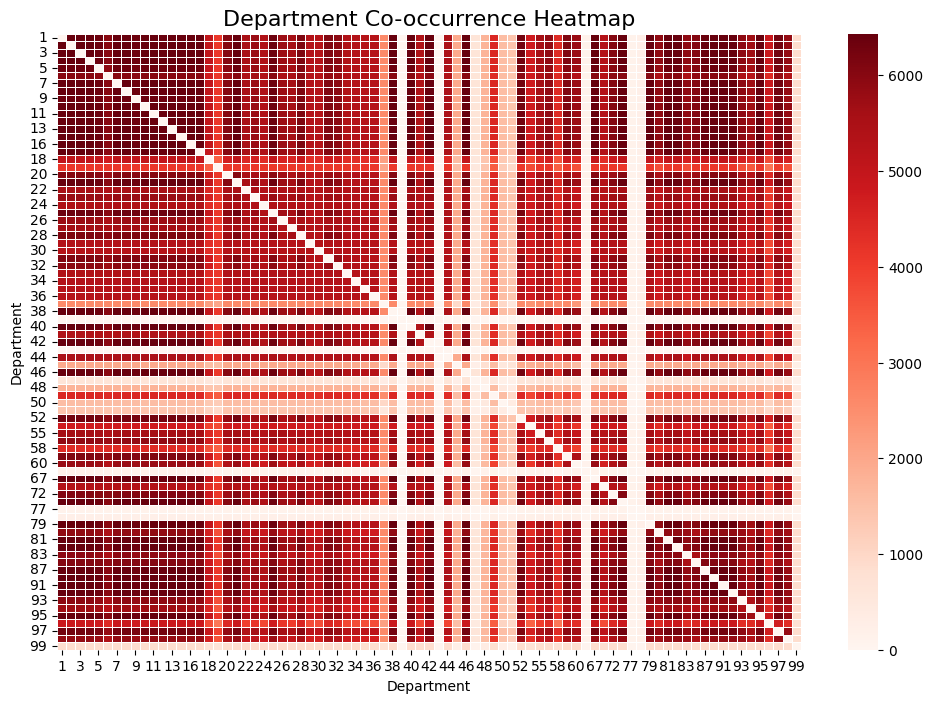

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Count']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Count'}, axis=1)
              .sort_values('Count', ascending=True))
  xs = counted['Count']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('Count', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Count')
_ = plt.ylabel('count()')

In [26]:
# ---------------------------
# Step 7: Market Basket Analysis (Simplified via Co-occurrence)
# ---------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter

# ✅ Assume `merged_dataset` is your dataset
# Transaction format: Each row is (Store, Week, Dept, Sales)
# Convert to a basket format: Store-Week vs Department
basket = merged_df.groupby(['Store', 'Date'])['Dept'].apply(set).reset_index()
basket.head()

# Build co-occurrence counts
pair_counter = Counter()
for dept_set in basket['Dept']:
    for combo in combinations(sorted(dept_set), 2):
        pair_counter[combo] += 1

# Convert to DataFrame
co_df = pd.DataFrame(pair_counter.items(), columns=['Pair', 'Count']).sort_values(by='Count', ascending=False)
print("Top Co-occurring Department Pairs:")
display(co_df.head(10))

# ---------------------------
# Heatmap Visualization
# ---------------------------
# Unique departments
departments = sorted(set().union(*basket['Dept']))

# Initialize co-occurrence matrix
co_matrix = pd.DataFrame(0, index=departments, columns=departments)

# Fill matrix
for (i, j), val in pair_counter.items():
    co_matrix.loc[i, j] = val
    co_matrix.loc[j, i] = val  # symmetric

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(co_matrix, cmap="Reds", linewidths=0.5)
plt.title("Department Co-occurrence Heatmap", fontsize=16)
plt.xlabel("Department")
plt.ylabel("Department")
plt.show()